In [1]:
from tensorflow import keras
from glob import glob

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.losses as losses

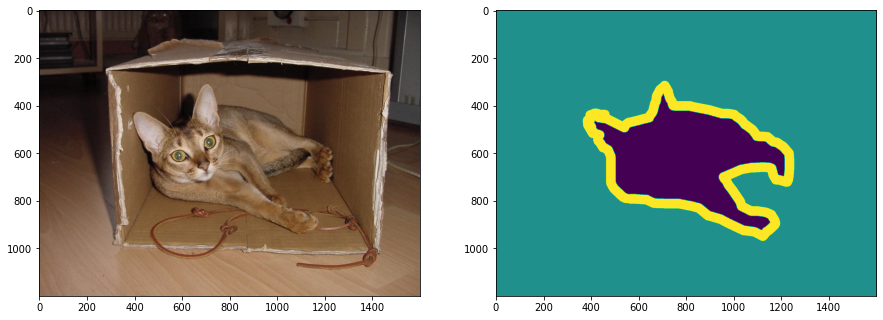

In [2]:
# C:\waterbean\PythonAI(5)\data\images
# data\images에서 134번 이미지를 선택해서 \annotations\trimaps 를 선택하여 두 이미지를 화면에 시각화

image_dir = "data\\images\\"
seg_dir = "data\\annotations\\trimaps\\"

image_files = glob(image_dir + "*.jpg") # 확장자 붙여주기
seg_files = glob(seg_dir + "*.png")

image_path = image_files[134] # 134번 이미지 선택
seg_path = image_path.replace(image_dir,seg_dir).replace('jpg','png')

image = cv2.imread(image_path) # 134번 이미지 표시
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #BGR -> RGB

seg_map = cv2.imread(seg_path,cv2.IMREAD_GRAYSCALE) # GRAYSCALE: 뒤의 배경 변환

plt.figure(figsize = (15,15))
plt.subplot(1,2,1) # 위치를 지정해주지 않으면 하나의 사진으로 겹쳐져 나온다.(실수한 부분)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(seg_map)

plt.show()

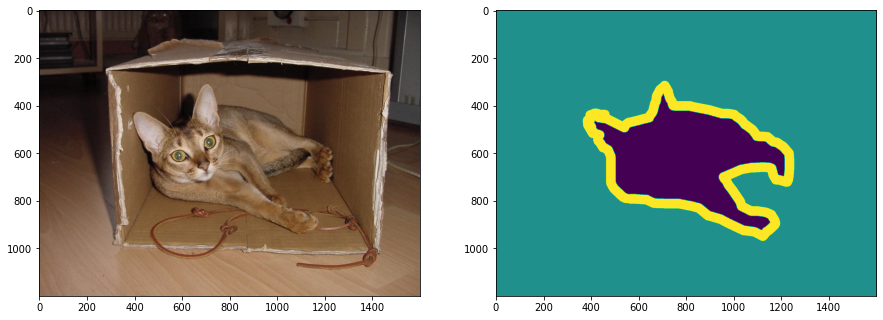

In [3]:
# 강사님 코드
image_files = glob('data/images/*.jpg')
image_path = image_files[134]
seg_path = image_path.replace('images','annotations/trimaps')
seg_path = seg_path.replace('jpg','png')

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
seg_map = cv2.imread(seg_path,cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(seg_map)
plt.show()

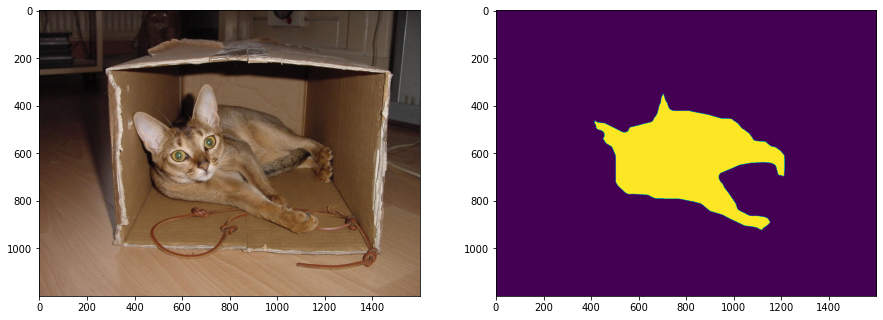

In [4]:
seg_map[seg_map != 1] = 0  # 배경 처리하기
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(seg_map)
plt.show()

# 1.  IoU(Intersection over Union)
* object detector의 정확도를 측정하는 데 이용되는 평가 지표
* ground-truth bounding boxes(testing set에서 object 위치를 labeling 한 것)
* prediceted bounding boxes(model이 출력한 object 위치 예측값) 필요
        
* IoU = $\frac{"Area of Overlap"}{"Area  of  Union"}$

* Area of Overlap : predicted bounding box와 ground - truth bounding box가 겹치는 부분
* Area of Union : predicted bounding box와 ground-truth bounding box를 둘러싸는 영역
* IoU : 0.4(poor), 0.7(Good), 0.9(Excellent)

In [5]:
# 해석해보기!
def iou(y_true,y_pred):
    smooth = 0.
    
    # Flatten(행렬의 평탄화 -> 자연수 계산을 가능하도록)
    y_true = tf.reshape(y_true, [-1]) # 차원 생성
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred) # 교집합
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    score = intersection / (union+smooth)
    
    return score

# 2. Dice coefficient
* 이미지 등의 Segmentation에서 사용되는 지표
* 영상 이미지 등에서 정답과 예측값 간의 차이를 읽기 위해 사용된다.

         2|X∩Y|
DSC = ------------
         |X|+|Y|
* 라벨링된 영역과 예측한 영역이 정확히 같다면 1, 그렇지 않은 경우는 0

In [6]:
def dice_coef(y_true,y_pred):
    smooth = 0.
    
    # Flatten(행렬의 평탄화 -> 자연수 계산을 가능하도록)
    y_true = tf.reshape(y_true, [-1]) # 차원 생성
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred) # 교집합 
    score = (2 * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
    return score

In [7]:
def dice_loss(y_true,y_pred):
    loss = 1 - dice_coef(y_true,y_pred)
    
    return loss

In [8]:
def bce_dice_loss(y_true,y_pred):
    loss = 1. * losses.binary_crossentropy(y_true,y_pred) + 1. * dice_loss(y_true,y_pred)
    
    return loss

In [9]:
print(dice_coef(seg_map.astype('float32'), seg_map.astype('float32')).numpy())

1.0
